In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [13]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [14]:
dataset = "Auto"
#dataset = "Pics/SchoolTrack/SchoolTrack_Cleaned_Mirrored_5"
#dataset = "Pics/RaceTrack/NewTrack_noFE_Cleaned_Mirrored_5"

In [15]:
# load images from both train and test groups
directory = '../../../../'+dataset+'/Train'
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 368


In [16]:
#Normalise images
images = np.array(images)
images /= 255.0

In [17]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

(array([1, 0, 0], dtype=uint8), <matplotlib.image.AxesImage at 0x1c97f09f7f0>)

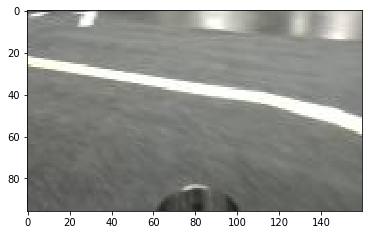

In [20]:
labels_speed[42], labels_dir[42], plt.imshow(images[42])

In [21]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

In [9]:
from keras.models import load_model
model = load_model("model_bigrace_original_5.h5")

OSError: Unable to open file (unable to open file: name = 'model_bigrace_original_5.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [22]:
'''
Model from PatateV2
'''

K.clear_session()
############################################################# 

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(24, (5,5), strides=(2,2), use_bias=False)(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(32, (5,5), strides=(2,2), use_bias=False)(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(64, (5,5), strides=(2,2), use_bias=False)(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(64, (3,3), strides=(2,2), use_bias=False)(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
x = BatchNormalization()(x)
x = Activation("relu")(x)

# Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
x = Dense(100, use_bias=False)(x)                                    # Classify the data into 100 features, make all negatives 0
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.2)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
x = Dense(50, use_bias=False)(x)                                     # Classify the data into 50 features, make all negatives 0
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.2)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)


# Multitask Output
out_speed = Dense(2, activation='softmax')(x)
out_dir = Dense(5, activation='softmax')(x)


# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

W1128 17:36:45.996417  6720 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:88: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1128 17:36:45.996417  6720 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:91: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1128 17:36:46.016362  6720 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1128 17:36:46.016362  6720 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:507

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 96, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 78, 24)        1800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 78, 24)        96        
_________________________________________________________________
activation_1 (Activation)    (None, 46, 78, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 37, 32)        19200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 37, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 21, 37, 32)        0         
__________

In [25]:
model_name="model_test_original_3.h5"

In [26]:
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [29]:
h = model.fit(images, [labels_speed, labels_dir], batch_size=64, epochs=10, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Train on 294 samples, validate on 74 samples
Epoch 1/100
294/294 [==============================] - 4s 14ms/step - loss: 0.1711 - acc: 0.9490 - val_loss: 4.2254 - val_acc: 0.3649

Epoch 00001: val_loss did not improve
Epoch 2/100
294/294 [==============================] - 4s 14ms/step - loss: 0.1258 - acc: 0.9728 - val_loss: 0.8601 - val_acc: 0.5405

Epoch 00002: val_loss did not improve
Epoch 3/100
294/294 [==============================] - 4s 14ms/step - loss: 0.1330 - acc: 0.9592 - val_loss: 1.7303 - val_acc: 0.4730

Epoch 00003: val_loss did not improve
Epoch 4/100
294/294 [==============================] - 4s 14ms/step - loss: 0.1164 - acc: 0.9762 - val_loss: 1.1536 - val_acc: 0.5946

Epoch 00004: val_loss did not improve
Epoch 5/100
294/294 [==============================] - 4s 14ms/step - loss: 0.0770 - acc: 0.9898 - val_loss: 0.7773 - val_acc: 0.7027

Epoch 00005: val_loss did not improve
Epoch 6/100
294/294 [==============================] - 4s 15ms/step - loss: 0.0762 - acc: 

KeyboardInterrupt: 

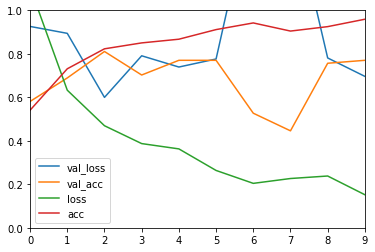

In [28]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [14]:
#######################  VALIDATION

In [29]:
from keras.models import load_model
model = load_model("../../" + model_name)

In [30]:
#print(model.to_json())

In [30]:
directory = '../../../../'+dataset+'/Val'
images_val, labels_speed_val, labels_dir_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

Loaded Images and labels for validation: 63


In [31]:
images_val = np.array(images_val)
images_val /= 255.0

In [32]:
# Get predictions
all_preds = model.predict(images_val)

speed_preds = []
for elem in all_preds[0]:
    speed_preds.append(np.argmax(elem))
    
dir_preds = []
for elem in all_preds[1]:
    dir_preds.append(np.argmax(elem))

In [33]:
res = 0
for i, value in enumerate(speed_preds):
    if value != labels_speed_val[i]:
        res += 1
print("error_rate = " + str(res/i))

IndexError: list index out of range

In [34]:
res = 0

i_0 = 1
res_0 = 0
res_0_1 = 0
res_0_2 = 0
res_0_3 = 0
res_0_4 = 0

i_1 = 1
res_1 = 0
res_1_1 = 0
res_1_2 = 0
res_1_3 = 0

i_2 = 1
res_2 = 0
res_2_1 = 0
res_2_2 = 0

i_3 = 1
res_3 = 0
res_3_1 = 0
res_3_2 = 0
res_3_3 = 0

i_4 = 1
res_4 = 0
res_4_1 = 0
res_4_2 = 0
res_4_3 = 0
res_4_4 = 0

for value in labels_dir_val:
    if value == 0:
        i_0 += 1
    elif value == 1:
        i_1 += 1
    elif value == 2:
        i_2 += 1
    elif value == 3:
        i_3 += 1
    elif value == 4:
        i_4 += 1

for i, value in enumerate(dir_preds):
    if value != labels_dir_val[i]:
        res += 1
        if labels_dir_val[i] == 0:    
            res_0 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_0_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_0_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_0_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_0_4 += 1
        elif labels_dir_val[i] == 1:
            res_1 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_1_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_1_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_1_3 += 1
        elif labels_dir_val[i] == 2:
            res_2 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_2_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_2_2 += 1
        elif labels_dir_val[i] == 3:
            res_3 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_3_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_3_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_3_3 += 1
        elif labels_dir_val[i] == 4:
            res_4 += 1
            if abs(labels_dir_val[i] - value) == 1:
                res_4_1 += 1
            elif abs(labels_dir_val[i] - value) == 2:
                res_4_2 += 1
            elif abs(labels_dir_val[i] - value) == 3:
                res_4_3 += 1
            elif abs(labels_dir_val[i] - value) == 4:
                res_4_4 += 1

        
print("total error = " + str(res/i), "0_error = " + str(res_0/i_0), "1_error = " + str(res_1/i_1), "2_error = " + str(res_2/i_2), "3_error = " + str(res_3/i_3), "4_error = " + str(res_4/i_4), )

total error = 1.0 0_error = 0.0 1_error = 0.0 2_error = 0.08333333333333333 3_error = 0.0 4_error = 0.0


Text(0.5, 1.0, 'Mean Errors by direction')

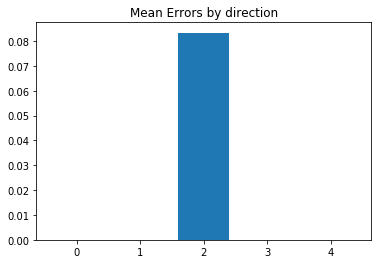

In [35]:
x = ['0','1','2','3','4']
plt.bar(x, height= [res_0/i_0, res_1/i_1, res_2/i_2, res_3/i_3, res_4/i_4])
plt.xticks(x, ['0','1','2','3','4']);
plt.title("Mean Errors by direction")

In [36]:
x = ['1','2','3','4']
plt.bar(x, height= [res_0_1/res_0, res_0_2/res_0, res_0_3/res_0, res_0_4/res_0])
plt.xticks(x, ['1','2','3','4']);
plt.title("0 Errors")

ZeroDivisionError: division by zero

In [37]:
x = ['1','2','3']
plt.bar(x, height= [res_1_1/res_1, res_1_2/res_1, res_1_3/res_1])
plt.xticks(x, ['0, 2','3', '4']);
plt.title("1 Errors")

ZeroDivisionError: division by zero

Text(0.5, 1.0, '2 Errors')

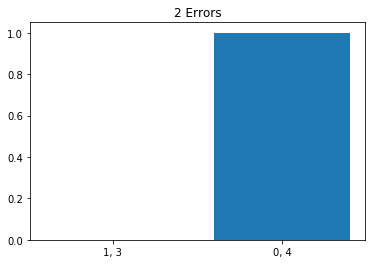

In [38]:
x = ['1','2']
plt.bar(x, height= [res_2_1/res_2, res_2_2/res_2])
plt.xticks(x, ['1, 3','0, 4']);
plt.title("2 Errors")

In [39]:
x = ['1','2','3']
plt.bar(x, height= [res_3_1/res_3, res_3_2/res_3, res_3_3/res_3])
plt.xticks(x, ['2, 4','1', '0']);
plt.title("3 Errors")

ZeroDivisionError: division by zero

In [40]:
x = ['1','2','3','4']
plt.bar(x, height= [res_4_1/res_4, res_4_2/res_4, res_4_3/res_4, res_4_4/res_4])
plt.xticks(x, ['3','2','1','0']);
plt.title("4 Errors")

ZeroDivisionError: division by zero

In [32]:
def layer_to_visualize(layer, img):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f([img])
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))

    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(16,16))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')


In [49]:
model.layers

Shape of conv: (46, 78, 24)


(<matplotlib.image.AxesImage at 0x21464abf240>, None)

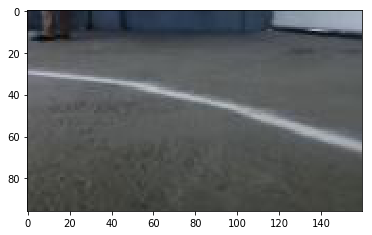

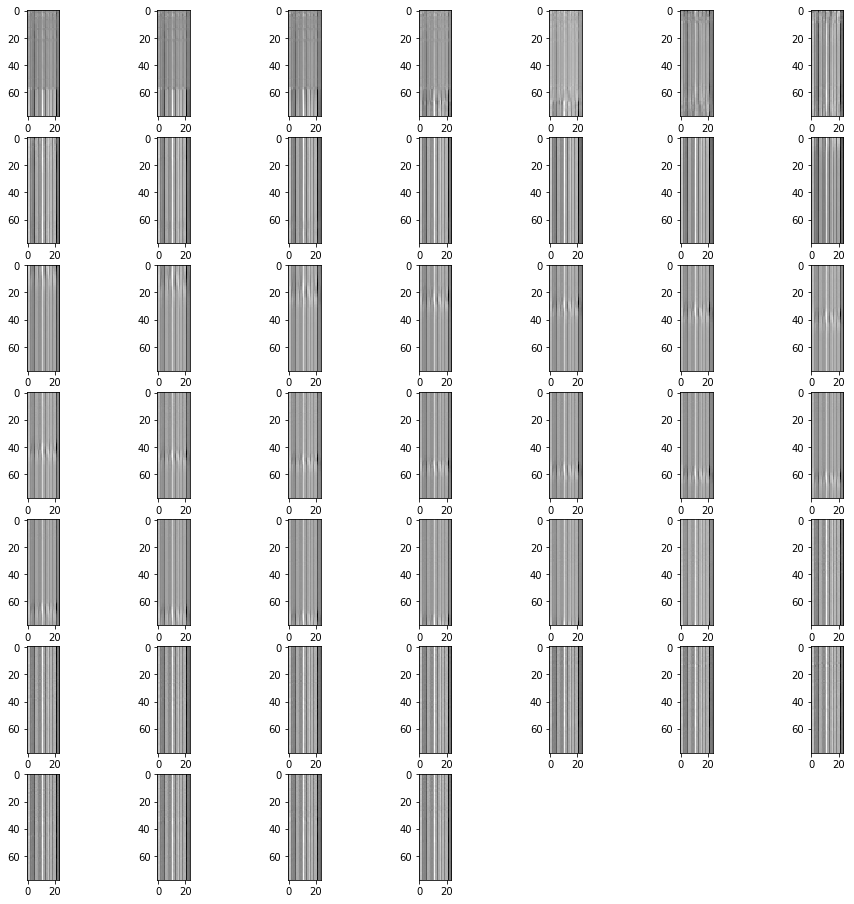

In [51]:
# Specify the layer to want to visualize
img_idx = 47
plt.imshow(images_val[img_idx]), layer_to_visualize(model.layers[1], images_val[img_idx])